In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
train_df = pd.read_csv('training_data.csv')

In [3]:
train_df.columns

Index(['Open(t-4)', 'Open(t-3)', 'Open(t-2)', 'Open(t-1)', 'Open(t)',
       'High(t-4)', 'High(t-3)', 'High(t-2)', 'High(t-1)', 'High(t)',
       'Low(t-4)', 'Low(t-3)', 'Low(t-2)', 'Low(t-1)', 'Low(t)',
       'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)', 'Close_x(t-1)',
       'Close_x(t)', 'Close_y(t-4)', 'Close_y(t-3)', 'Close_y(t-2)',
       'Close_y(t-1)', 'Close_y(t)', 'Volume(t-4)', 'Volume(t-3)',
       'Volume(t-2)', 'Volume(t-1)', 'Volume(t)', 'Average_Likes(t-4)',
       'Average_Likes(t-3)', 'Average_Likes(t-2)', 'Average_Likes(t-1)',
       'Average_Likes(t)', 'Tweets_Volume(t-4)', 'Tweets_Volume(t-3)',
       'Tweets_Volume(t-2)', 'Tweets_Volume(t-1)', 'Tweets_Volume(t)',
       'reddit_sentiment(t-4)', 'reddit_sentiment(t-3)',
       'reddit_sentiment(t-2)', 'reddit_sentiment(t-1)', 'reddit_sentiment(t)',
       'twitter_sentiment(t-4)', 'twitter_sentiment(t-3)',
       'twitter_sentiment(t-2)', 'twitter_sentiment(t-1)',
       'twitter_sentiment(t)', 'roe', 'infl', 

## Preprocessing

### Generate Column Ordering

In [4]:
# time series columns
cols_series = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'Average_Likes', 'Tweets_Volume','reddit_sentiment', 'twitter_sentiment' ]
# uni value columns
cols_unival = ['roe', 'infl', 'Close_x1(t+1)']

In [5]:
col_order = []
cur = pd.Series(train_df.columns)

for col in cols_series:
    filtered = list(cur[cur.str.startswith(col)])
    if (col == 'Close_x'):
        filtered.remove('Close_x1(t+1)')
    col_order.extend(filtered)

col_order.extend(cols_unival)

In [6]:
col_order

['Open(t-4)',
 'Open(t-3)',
 'Open(t-2)',
 'Open(t-1)',
 'Open(t)',
 'High(t-4)',
 'High(t-3)',
 'High(t-2)',
 'High(t-1)',
 'High(t)',
 'Low(t-4)',
 'Low(t-3)',
 'Low(t-2)',
 'Low(t-1)',
 'Low(t)',
 'Close_x(t-4)',
 'Close_x(t-3)',
 'Close_x(t-2)',
 'Close_x(t-1)',
 'Close_x(t)',
 'Close_y(t-4)',
 'Close_y(t-3)',
 'Close_y(t-2)',
 'Close_y(t-1)',
 'Close_y(t)',
 'Volume(t-4)',
 'Volume(t-3)',
 'Volume(t-2)',
 'Volume(t-1)',
 'Volume(t)',
 'Average_Likes(t-4)',
 'Average_Likes(t-3)',
 'Average_Likes(t-2)',
 'Average_Likes(t-1)',
 'Average_Likes(t)',
 'Tweets_Volume(t-4)',
 'Tweets_Volume(t-3)',
 'Tweets_Volume(t-2)',
 'Tweets_Volume(t-1)',
 'Tweets_Volume(t)',
 'reddit_sentiment(t-4)',
 'reddit_sentiment(t-3)',
 'reddit_sentiment(t-2)',
 'reddit_sentiment(t-1)',
 'reddit_sentiment(t)',
 'twitter_sentiment(t-4)',
 'twitter_sentiment(t-3)',
 'twitter_sentiment(t-2)',
 'twitter_sentiment(t-1)',
 'twitter_sentiment(t)',
 'roe',
 'infl',
 'Close_x1(t+1)']

In [7]:
# Order the dataframe columns for scaling
train_df = train_df[col_order]

### Row MinMax Scaling

In [8]:
train_scaled = train_df.copy()

In [9]:
train_scaled.columns

Index(['Open(t-4)', 'Open(t-3)', 'Open(t-2)', 'Open(t-1)', 'Open(t)',
       'High(t-4)', 'High(t-3)', 'High(t-2)', 'High(t-1)', 'High(t)',
       'Low(t-4)', 'Low(t-3)', 'Low(t-2)', 'Low(t-1)', 'Low(t)',
       'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)', 'Close_x(t-1)',
       'Close_x(t)', 'Close_y(t-4)', 'Close_y(t-3)', 'Close_y(t-2)',
       'Close_y(t-1)', 'Close_y(t)', 'Volume(t-4)', 'Volume(t-3)',
       'Volume(t-2)', 'Volume(t-1)', 'Volume(t)', 'Average_Likes(t-4)',
       'Average_Likes(t-3)', 'Average_Likes(t-2)', 'Average_Likes(t-1)',
       'Average_Likes(t)', 'Tweets_Volume(t-4)', 'Tweets_Volume(t-3)',
       'Tweets_Volume(t-2)', 'Tweets_Volume(t-1)', 'Tweets_Volume(t)',
       'reddit_sentiment(t-4)', 'reddit_sentiment(t-3)',
       'reddit_sentiment(t-2)', 'reddit_sentiment(t-1)', 'reddit_sentiment(t)',
       'twitter_sentiment(t-4)', 'twitter_sentiment(t-3)',
       'twitter_sentiment(t-2)', 'twitter_sentiment(t-1)',
       'twitter_sentiment(t)', 'roe', 'infl', 

In [10]:
# transformation dictionary to store each row's minimum value and range (max-min)
trform_list = {}

In [11]:
def minmaxscaler(index, row, in_size, num_var):
    trform_dict = {}
    trformed_row = []
    value = 0
    for i in range(num_var):
        cur = np.array(row[ i*in_size : (i+1)*in_size ])
        rowmaxmin = cur.max() - cur.min()
        rowmin = cur.min()
        trform_dict[i] = [rowmaxmin, rowmin]
        trform_list[index] = trform_dict
        cur = [ (x - rowmin) / (rowmaxmin) for x in cur]
        trformed_row.extend(cur)
        if (i == 3):
            target = row[-1]
            value = (target - rowmin) / rowmaxmin
    
    rest = np.array(row[ num_var*in_size : -1 ])
    trformed_row.extend(rest)
    trformed_row.append(value)
    return trformed_row

In [12]:
for index, row in train_scaled.iterrows():
    trformed_row = minmaxscaler(index, row, 5, 8)
    train_scaled.loc[index] = trformed_row

In [13]:
trform_list

{0: {0: [4.386064828000329, 37.64469954219178],
  1: [1.65090734192961, 41.35737127213854],
  2: [4.66452364174642, 37.129117884311526],
  3: [1.72845458984375, 40.82010269165039],
  4: [86.31005859375, 2709.800048828125],
  5: [465456000.0, 364944800.0],
  6: [1.5851742151109245, 1.0555014605647517],
  7: [2621.0, 4779.0]},
 1: {0: [1.5074074219748042, 41.0629207043366],
  1: [1.6066107300115746, 41.73314634803784],
  2: [1.2168728441418253, 40.57676868191612],
  3: [2.4664230346679688, 40.82010269165039],
  4: [86.31005859375, 2709.800048828125],
  5: [198640400.0, 364944800.0],
  6: [0.24155930113495705, 0.864529838852488],
  7: [868.0, 4779.0]},
 2: {0: [2.4897590017422218, 41.0629207043366],
  1: [3.8495720033273955, 41.73314634803784],
  2: [2.417169543947253, 40.98307460171824],
  3: [4.25848388671875, 41.234710693359375],
  4: [57.33984375, 2775.60009765625],
  5: [244424400.0, 364944800.0],
  6: [0.24155930113495705, 0.864529838852488],
  7: [2272.0, 4779.0]},
 3: {0: [4.51012

In [14]:
train_scaled.head()

,Open(t-4),Open(t-3),Open(t-2),Open(t-1),Open(t),High(t-4),High(t-3),High(t-2),High(t-1),High(t),...,reddit_sentiment(t-1),reddit_sentiment(t),twitter_sentiment(t-4),twitter_sentiment(t-3),twitter_sentiment(t-2),twitter_sentiment(t-1),twitter_sentiment(t),roe,infl,Close_x1(t+1)
0,0.000000,0.912385,0.800851,0.779337,1.0,0.000000,0.570608,0.227617,0.724460,1.000000,...,0.0,0.0,0.127374,0.256366,0.244529,0.207746,0.318402,0.10921,0.190660,1.426953
1,0.387128,0.062601,0.000000,0.642058,1.0,0.352448,0.000000,0.510541,0.793678,1.000000,...,0.0,0.0,0.256366,0.244529,0.207746,0.318402,0.206934,0.10921,0.237069,1.894684
2,0.037901,0.000000,0.388730,0.605443,1.0,0.000000,0.213073,0.331240,0.417348,1.000000,...,0.0,0.0,0.244529,0.207746,0.318402,0.206934,0.247462,0.10921,0.283478,1.040911
3,0.000000,0.214593,0.334227,0.552037,1.0,0.000000,0.086161,0.148946,0.573785,1.000000,...,0.0,0.0,0.207746,0.318402,0.206934,0.247462,0.230397,0.10921,0.329887,1.172295
4,0.000000,0.124233,0.350416,0.815599,1.0,0.000000,0.068705,0.533599,1.000000,0.758777,...,0.0,0.0,0.318402,0.206934,0.247462,0.230397,0.148224,0.10921,0.376296,1.575699


## Training

In [15]:
score_df = pd.DataFrame(columns=['gs_cv', 'data', "MAE", "MSE", "RMSE", "R2"])

### Train Test Split

In [16]:
# Take last 50 days as test data
x = train_scaled.drop("Close_x1(t+1)", axis=1)
y = train_scaled["Close_x1(t+1)"]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=88, test_size=0.25, shuffle=False)

In [17]:
# Shuffle the first 150 days as train data
X_train, y_train = shuffle(X_train, y_train, random_state=0)

### AdaBoost without Grid Search

In [18]:
# Training without GridSearch and CV
model = AdaBoostRegressor(random_state=42)
model.fit(X_train, y_train)

AdaBoostRegressor(random_state=42)

### Accuracy on Test Data (Last 50 Days)

In [19]:
pred = model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y_test[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = [False, 'test', mae, mse, rmse, r2]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)   

Mean Absolute Error: 7.0751577895098015
Mean Squared Error: 67.30510694409492
Root Mean Squared Error: 8.203968975081203
R-squared: 0.5701919320410863


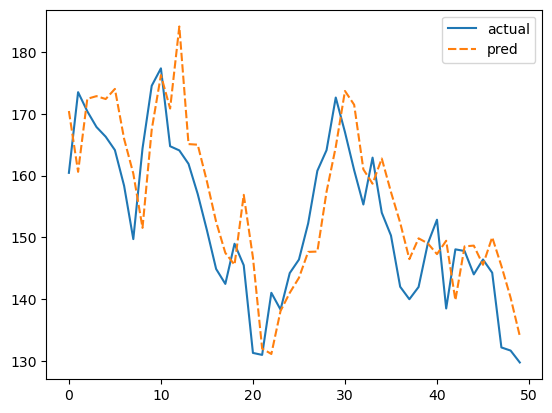

In [20]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})
sns.lineplot(data=output)
plt.show()

### Accuracy on the Complete Data (200 days)

In [21]:
validation_pred = model.predict(x)
validation_y = y
v_pred_trformed = [validation_pred[x] * trform_list[x][2][0] + trform_list[x][2][1] for x in validation_y.index]
v_y_trformed = [validation_y[x] * trform_list[x][2][0] + trform_list[x][2][1] for x in validation_y.index]

mae = mean_absolute_error(v_y_trformed, v_pred_trformed)
mse = mean_squared_error(v_y_trformed, v_pred_trformed)
rmse = mean_squared_error(v_y_trformed, v_pred_trformed, squared=False)
r2 = r2_score(v_y_trformed, v_pred_trformed)
score_df.loc[len(score_df)] = [False, 'all', mae, mse, rmse, r2]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)   

Mean Absolute Error: 3.7944118216868
Mean Squared Error: 36.53743111883061
Root Mean Squared Error: 6.044620014428584
R-squared: 0.97728331044813


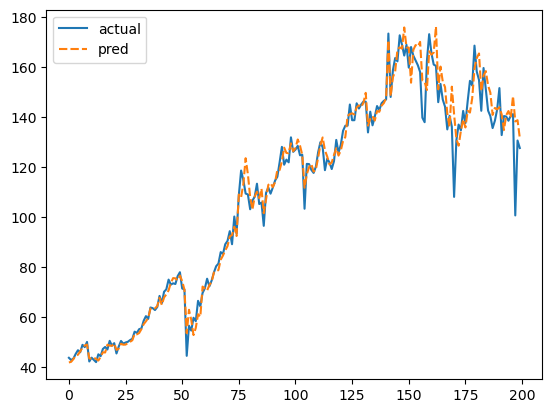

In [22]:
output = pd.DataFrame({'actual': v_y_trformed, 'pred': v_pred_trformed})
sns.lineplot(data=output)
plt.show()

### AdaBoost with GridSearch

In [23]:
# Training with GridSearch CV to find best parameters

# Define parameter grid for GridSearchCV
param_grid = {
    'base_estimator__max_depth': range(1, 6),
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5],
    'n_estimators': [10, 20, 30, 40, 50, 60],
    'loss': ['linear', 'square', 'exponential']
}

# Define AdaBoost model
base_estimator = DecisionTreeRegressor()
model = AdaBoostRegressor(base_estimator=base_estimator, random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print results
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

# Use best model to make predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, predictions)
print(f'Mean squared error: {mse}')

Best parameters: {'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 20}
Best score: -0.3705455996315895
Mean squared error: 0.5469860503431953


Best Parameters and model score

Best parameters: {'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 20}

Best score: -0.3705455996315895

Mean squared error: 0.5469860503431953

In [24]:
base_estimator = DecisionTreeRegressor(max_depth=3)
best_model = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=20, learning_rate=0.1, loss='square')
best_model.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=0.1, loss='square', n_estimators=20)

### Accuracy on Test Data (Last 50 Days)

In [25]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y_test[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = [True, 'test', mae, mse, rmse, r2]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)   

Mean Absolute Error: 7.407027038576834
Mean Squared Error: 71.76493446210037
Root Mean Squared Error: 8.471418680604824
R-squared: 0.5417116288965402


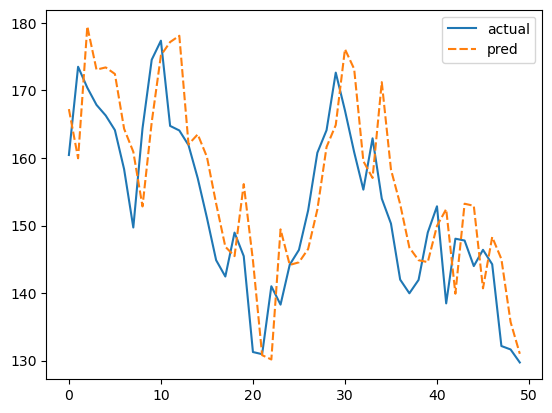

In [26]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})
sns.lineplot(data=output)
plt.show()

### Accuracy on the Complete Data (200 days)

In [27]:
validation_pred = best_model.predict(train_scaled.drop('Close_x1(t+1)',axis=1))
validation_y = train_scaled['Close_x1(t+1)']
v_pred_trformed = [validation_pred[x] * trform_list[x][2][0] + trform_list[x][2][1] for x in validation_y.index]
v_y_trformed = [validation_y[x] * trform_list[x][2][0] + trform_list[x][2][1] for x in validation_y.index]

mae = mean_absolute_error(v_y_trformed, v_pred_trformed)
mse = mean_squared_error(v_y_trformed, v_pred_trformed)
rmse = mean_squared_error(v_y_trformed, v_pred_trformed, squared=False)
r2 = r2_score(v_y_trformed, v_pred_trformed)
score_df.loc[len(score_df)] = [True, 'all', mae, mse, rmse, r2]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)   

Mean Absolute Error: 4.016219199197421
Mean Squared Error: 37.86425847035594
Root Mean Squared Error: 6.153394061032979
R-squared: 0.9764583721831627


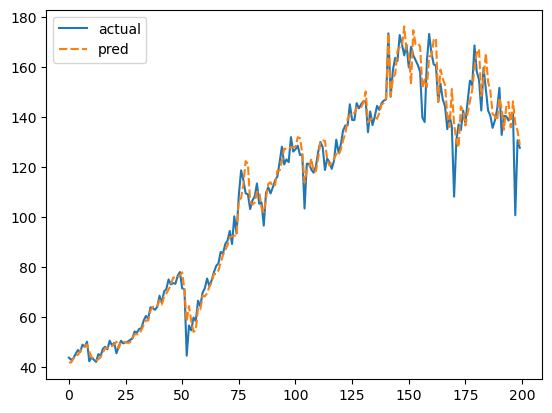

In [28]:
output = pd.DataFrame({'actual': v_y_trformed, 'pred': v_pred_trformed })
sns.lineplot(data=output)
plt.show()

In [29]:
score_df

,gs_cv,data,MAE,MSE,RMSE,R2
0,False,test,7.075158,67.305107,8.203969,0.570192
1,False,all,3.794412,36.537431,6.044620,0.977283
2,True,test,7.407027,71.764934,8.471419,0.541712
3,True,all,4.016219,37.864258,6.153394,0.976458
